### Hydrogen Molecule

https://medium.com/@avpol111/modeling-an-atom-with-qiskit-ab851b8ff6a5

In [2]:
# first, DistanceUnit for the distance between atoms in a molecule:
from qiskit_nature.units import DistanceUnit
# then, PySCFDriver to build our model (pyscf is a quantum chemistry library):
from qiskit_nature.second_q.drivers import PySCFDriver
# now, two solvers: the second one is a generic solver that will use the first
# one to actually solve the problem:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
# finally, a mapper that maps spin operators onto fermionic creation and
# annihilation operators (it'll be used in the solver):
from qiskit_nature.second_q.mappers import JordanWignerMapper

In [93]:
import numpy as np

distances = np.linspace(0.25, 4, 100)
energies = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)

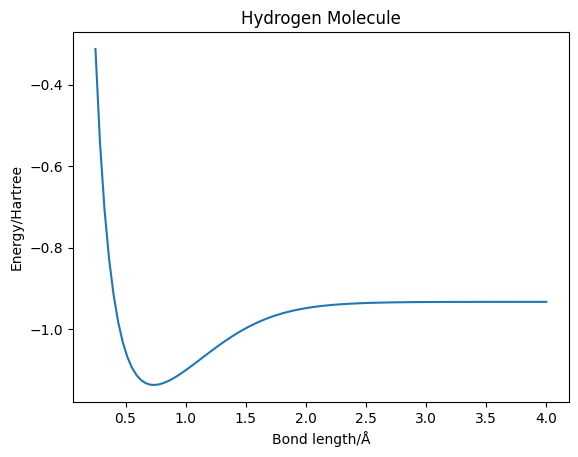

In [94]:
import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.show()

### VQE

https://qiskit-community.github.io/qiskit-nature/tutorials/03_ground_state_solvers.html#

https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html

https://qiskit.org/ecosystem/aer/tutorials/2_device_noise_simulation.html

https://medium.com/@minhanh.dongnguyen/breaking-down-how-to-simulate-molecules-chemical-reactions-using-variational-quantum-eigensolver-43b770c888e0

https://calebclothier.medium.com/variational-quantum-eigensolvers-95e7dd51b9df

To break down the steps of VQE:

1. Using Hartree-Fock to make an educated guess of the wave function of our molecule, taking into account the geometry of the molecule, electronic orbitals and the number of electrons involved.

1. Encode this information into the qubits of the quantum computer. The energy is a function of some parameters that we can choose like the geometry of the molecule. The guess of the wave function is the ansatz and the process of encoding this information into the quantum computer is mapping.

1. Given the ansatz, the quantum computer will perform a series of calculations to get the energy of the molecule.

1. The energy is then returned to the classical optimizer, which then updates the ansatz. Once the energy at this interatomic distance converges to a minimum value, the algorithm then moves to the next interatomic distance and the algorithm repeats.

In [3]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

In [139]:
distances = np.linspace(0.25, 4, 10)
energies = []
energies_vqe = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)


    # VQE:
    mapper = JordanWignerMapper()

    """
    In order to reduce the number of parameters and hence the size of the algorithmic
    search space, an ansatz (German for guess) is often made regarding the form of the
    ground state wavefunction, with this ansatz determining the exact configuration of
    the parametrized quantum circuit. The choice of optimal ansatz varies across VQE
    applications and is informed by the Hamiltonian of the system being studied.

    the Hartree Fock initial state preparation circuit and the UCCSD variational unitary
    transformation circuit (with HF as its initial state) were retrieved from a library of
    optimized circuits in the qiskit_nature.second_q.circuit.library module.
    """

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    result_vqe = calc.solve(problem)
    energies_vqe.append(result_vqe.groundenergy + hamiltonian.nuclear_repulsion_energy)

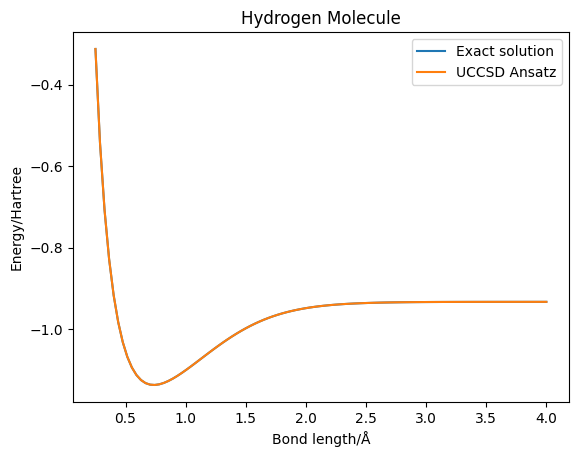

In [140]:
import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
import numpy as np
 
service = QiskitRuntimeService()

# Run on the least-busy backend you have access to
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend = service.get_backend('ibmq_qasm_simulator')

options = Options()
 
# Create an Estimator object
estimator = Estimator(backend=backend, options=options)

distances = np.linspace(0.25, 4, 100)
energies = []
energies_vqe = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)

    # VQE:
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(estimator, ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    
    """
    calc = GroundStateEigensolver(mapper, vqe_solver)
    result_vqe = calc.solve(problem)
    energies_vqe.append(result_vqe.groundenergy + hamiltonian.nuclear_repulsion_energy)
    """
    energies_vqe.append(vqe_solver.compute_minimum_eigenvalue(operator=problem) + hamiltonian.nuclear_repulsion_energy)

import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

AttributeError: 'ElectronicStructureProblem' object has no attribute 'num_qubits'

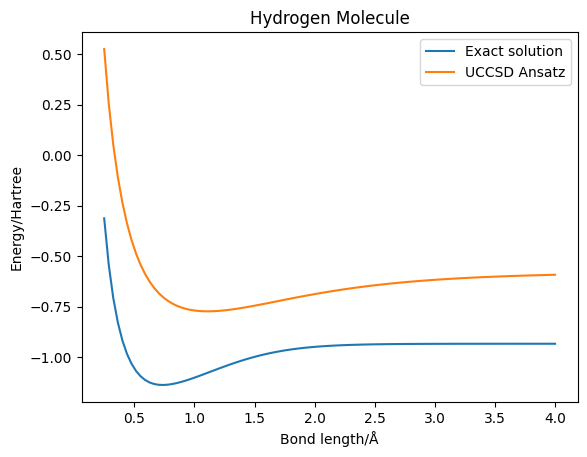

In [9]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigo
from qiskit_aer import AerSimulator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

# fake providers contain data from real IBM Quantum devices stored in Qiskit,
# and are useful for extracting realistic noise models.
# Crear un modelo de ruido a partir de un backend simulado
simulator_backend = AerSimulator.from_backend(FakeVigo())
noise_model = NoiseModel.from_backend(simulator_backend)

seed = 170
algorithm_globals.random_seed = seed

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

distances = np.linspace(0.25, 4, 100)
energies = []
energies_vqe = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)

    
    # VQE:
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.estimator = noisy_estimator

    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    result_vqe = calc.solve(problem)

    energies_vqe.append(result_vqe.groundenergy + hamiltonian.nuclear_repulsion_energy)


import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

/home/tfg/TFG/lib/python3.10/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend <IBMBackend('ibmq_qasm_simulator')> has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


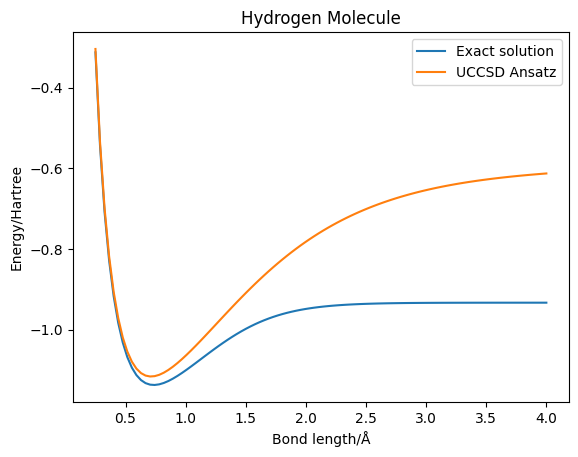

In [8]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Build noise model from backend properties
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
 
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

seed = 170
algorithm_globals.random_seed = seed

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

distances = np.linspace(0.25, 4, 100)
energies = []
energies_vqe = []

for distance in distances:
    # build the model:
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    # it'll return an instance of ElectronicStructureProblem:
    problem = driver.run()

    # and now, let's build a solver, get and print the results:
    solver = GroundStateEigensolver(
        JordanWignerMapper(),
        NumPyMinimumEigensolver(),
    )

    hamiltonian = problem.hamiltonian
    result = solver.solve(problem)
    energies.append(result.groundenergy + hamiltonian.nuclear_repulsion_energy)


    # VQE:
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper,
        ),
    )

    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.estimator = noisy_estimator
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    calc = GroundStateEigensolver(mapper, vqe_solver)
    result_vqe = calc.solve(problem)
    energies_vqe.append(result_vqe.groundenergy + hamiltonian.nuclear_repulsion_energy)


import matplotlib.pyplot as plt

plt.plot(distances, energies, marker='', linestyle='-', label='Exact solution')
plt.plot(distances, energies_vqe, marker='', linestyle='-', label='UCCSD Ansatz')
plt.xlabel('Bond length/Å')
plt.ylabel('Energy/Hartree')
plt.title('Hydrogen Molecule')
plt.legend()
plt.show()

/home/tfg/TFG/lib/python3.10/site-packages/qiskit_aer/noise/noise_model.py:379: UserWarning: Qiskit backend <IBMBackend('ibmq_qasm_simulator')> has no QubitProperties, so the resulting noise model will not include any thermal relaxation errors.
  warn(


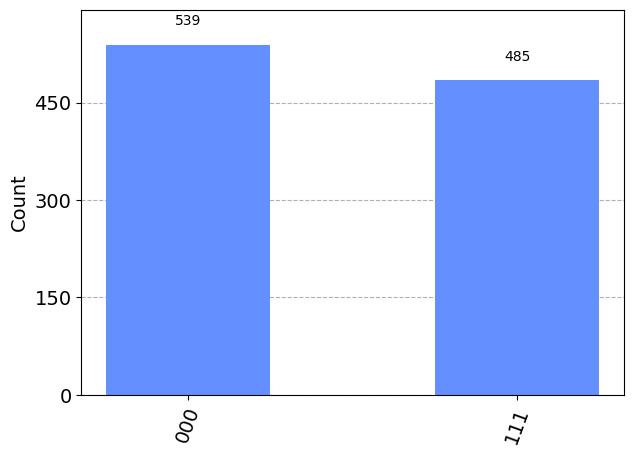

In [119]:
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Build noise model from backend properties
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')
noise_model = NoiseModel.from_backend(backend)
 
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
 
# Get basis gates from noise model
basis_gates = noise_model.basis_gates
 
# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])
 
# Perform a noise simulation
result = execute(circ, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

El mensaje de advertencia que estás viendo indica que el simulador QasmSimulator que estás utilizando no tiene propiedades de qubits asociadas (QubitProperties). Las propiedades de qubits incluyen información sobre características como los tiempos de relajación térmica, pero en este caso, el simulador no proporciona esa información.

La advertencia en sí misma no es un error crítico y no debería afectar tu capacidad para ejecutar tu código. Sin embargo, si estás interesado en modelar efectos más detallados de ruido cuántico, podrías considerar cambiar a un simulador que proporcione propiedades de qubits, como el simulador ibmq_qasm_simulator que emula un dispositivo real.

In [135]:
from qiskit import IBMQ

# Cargar tu cuenta de IBM Quantum
IBMQ.load_account()

# Obtener los proveedores disponibles
providers = IBMQ.providers()

# Iterar sobre los proveedores y sus backends
for provider in providers:
    print("Provider:", provider)
    for backend in provider.backends():
        print("    Backend:", backend)
        if backend.configuration().n_qubits >= 5 and not backend.configuration().simulator:
            print("        Qubits:", backend.configuration().n_qubits)
            
            # Verificar la disponibilidad de relaxation_times
            if hasattr(backend.properties(), 'relaxation_times') and backend.properties().relaxation_times():
                print("        Tiempo de relajación térmica:", backend.properties().relaxation_times()[0].value)
            else:
                print("        Información de relajación térmica no disponible para este backend.")
            break


ibmqfactory.load_account:WARNING:2024-02-04 15:27:05,733: Credentials are already in use. The existing account in the session will be replaced.


Provider: <AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>
    Backend: ibmq_qasm_simulator
    Backend: simulator_statevector
    Backend: simulator_mps
    Backend: simulator_extended_stabilizer
    Backend: simulator_stabilizer
    Backend: ibm_brisbane
        Qubits: 127
        Información de relajación térmica no disponible para este backend.
